# Malaria Detection using Machine Learning with Dimension Reduction

## Project Overview
This notebook implements a comprehensive approach to malaria detection from blood cell images using various machine learning techniques with a focus on dimension reduction methods.

### Dataset Challenges and Preprocessing Strategy

**Mixed Image Formats Issue:**
- The dataset contains images in different formats (.tiff and .png)
- For consistent processing, we will standardize all images to PNG format
- This ensures uniform handling across the entire pipeline

**Class Imbalance Problem:**
- Training set: 4,000 negative vs 800 positive samples (~5:1 ratio)
- Validation set: 1,531 negative vs 1,035 positive samples (~1.5:1 ratio)
- This significant imbalance requires special handling techniques

### Techniques to Handle Class Imbalance:

1. **Data-Level Approaches:**
   - **Data Augmentation:** Apply transformations specifically to minority class

2. **Algorithm-Level Approaches:**
   - **Class Weights:** Assign higher weights to minority class during training

3. **Evaluation Strategies:**
   - **Stratified Cross-Validation:** Maintain class distribution in folds
   - **Balanced Metrics:** Use F1-score, precision, recall, and AUC-ROC instead of just accuracy
   - **Confusion Matrix Analysis:** Detailed analysis of true/false positives and negatives

4. **Ensemble Methods:**
   - **Balanced Random Forest:** Built-in handling of class imbalance
   - **EasyEnsemble:** Combine multiple balanced classifiers
   - **BalanceCascade:** Sequential ensemble with balanced sampling

### Implementation Plan:
We will implement and compare multiple approaches to find the most effective combination for this specific dataset and problem.


## Data Exploration and Preprocessing

In this section, we will:
1. Load and examine the dataset structure
2. Analyze image properties and distributions
3. Visualize sample images from both classes
4. Implement preprocessing pipeline for format standardization
5. Apply class imbalance handling techniques
6. Prepare data for dimension reduction experiments


In [79]:
import os
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [80]:
BASE_PATH = Path('malaria_dataset')
TRAIN_PATH = BASE_PATH / 'train'
VAL_PATH = BASE_PATH / 'val'

TRAIN_NEGATIVE = TRAIN_PATH / 'negative'
TRAIN_POSITIVE = TRAIN_PATH / 'positive'
VAL_NEGATIVE = VAL_PATH / 'negative'
VAL_POSITIVE = VAL_PATH / 'positive'

print("Dataset Structure:")
print(f"Base path: {BASE_PATH}")
print(f"Training path: {TRAIN_PATH}")
print(f"Validation path: {VAL_PATH}")


Dataset Structure:
Base path: malaria_dataset
Training path: malaria_dataset/train
Validation path: malaria_dataset/val


# Examining the Dataset

When examining the malaria dataset, we noticed that the images come in two different formats: TIFF and PNG. If we train a model directly on this mixed-format dataset, the model may unintentionally learn to distinguish file format artifacts instead of actual malaria parasites. To prevent this and ensure the model learns meaningful medical features, we need to convert all images into a consistent format.

To understand how many images exist in each format, we can run the following cell to count them:

In [81]:
# Function to count files by extension in each directory
def count_files_by_extension(directory):
    """Count files by their extensions in a directory"""
    extensions = {}
    if directory.exists():
        for file_path in directory.iterdir():
            if file_path.is_file():
                ext = file_path.suffix.lower()
                extensions[ext] = extensions.get(ext, 0) + 1
    return extensions

directories = [
    ("Training Negative", TRAIN_NEGATIVE),
    ("Training Positive", TRAIN_POSITIVE), 
    ("Validation Negative", VAL_NEGATIVE),
    ("Validation Positive", VAL_POSITIVE)
]

total_tiff = 0
total_png = 0
total_other = 0

for dir_name, dir_path in directories:
    file_counts = count_files_by_extension(dir_path)
    print(f"\n{dir_name}: {file_counts}")
    
    # Count specific formats
    tiff_count = file_counts.get('.tiff', 0) + file_counts.get('.tif', 0)
    png_count = file_counts.get('.png', 0)
    other_count = sum(count for ext, count in file_counts.items() 
                     if ext not in ['.tiff', '.tif', '.png'])
    
    total_tiff += tiff_count
    total_png += png_count
    total_other += other_count
    
    print(f"  - TIFF files: {tiff_count}")
    print(f"  - PNG files: {png_count}")
    print(f"  - Other files: {other_count}")

print()
print(f"Total TIFF files: {total_tiff}")
print(f"Total PNG files: {total_png}")
print(f"Total other files: {total_other}")
print(f"Total image files: {total_tiff + total_png}")



Training Negative: {'.png': 4000}
  - TIFF files: 0
  - PNG files: 4000
  - Other files: 0

Training Positive: {'.png': 800}
  - TIFF files: 0
  - PNG files: 800
  - Other files: 0

Validation Negative: {'.png': 1531}
  - TIFF files: 0
  - PNG files: 1531
  - Other files: 0

Validation Positive: {'.png': 1034, '.db': 1}
  - TIFF files: 0
  - PNG files: 1034
  - Other files: 1

Total TIFF files: 0
Total PNG files: 7365
Total other files: 1
Total image files: 7365


# Dataset Format: TIFF and PNG

Based on the above analysis, we see that the dataset contains a mix of TIFF and PNG images, with all Negative training samples in TIFF format (4000 images) and most Positive samples in PNG format (800 training + all validation). Because of this imbalance, the model would learn to distinguish file formats instead of learning malaria-specific visual features. To avoid this issue and ensure consistent preprocessing, we will convert the entire dataset into PNG format.

We choose PNG because more than 45% of the dataset is already in PNG, and PNG is a widely used, lossless image format commonly used in biomedical imaging. In fact, standard malaria image benchmarks; such as the NIH Malaria Dataset (27,558 cell images) also distribute images in PNG/JPEG format, not TIFF. This means PNG is already accepted as a standard for malaria cell classification, and converting everything to PNG ensures compatibility with commonly used deep learning pipelines and pretrained models (e.g., ResNet, VGG), which expect standard RGB inputs rather than high–bit depth TIFF files.

One other files called Thumbs.db, which is a thumbnail cache file for Windows was found in the validation positive directory. We should remove it.

In [82]:
# Image Format Standardization - Convert all images to PNG
from PIL import Image

def convert_images_to_png(source_dir):
    """
    Convert all TIFF images to PNG format in place
    
    Args:
        source_dir: Directory containing images to convert
    """
    if not source_dir.exists():
        print(f"Directory {source_dir} does not exist")
        return
    
    # Get all TIFF files
    tiff_files = list(source_dir.glob('*.tiff')) + list(source_dir.glob('*.tif'))
    
    if not tiff_files:
        print(f"No TIFF files found in {source_dir}")
        return
    
    print(f"Converting {len(tiff_files)} TIFF files to PNG in {source_dir}...")
    
    converted_count = 0
    for tiff_file in tiff_files:
        try:
            # Create PNG filename
            png_file = tiff_file.with_suffix('.png')
            
            # Convert TIFF to PNG
            with Image.open(tiff_file) as img:
                # Convert to RGB if necessary (TIFF might have different modes)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Save as PNG
                img.save(png_file, 'PNG', optimize=True)
            
            # Remove original TIFF file
            tiff_file.unlink()
            converted_count += 1
            
            print(f"  ✓ Converted: {tiff_file.name} → {png_file.name}")
            
        except Exception as e:
            print(f"  ✗ Error converting {tiff_file.name}: {e}")
    
    print(f"Successfully converted {converted_count} files to PNG format")

directories_to_convert = [
    ("Training Negative", TRAIN_NEGATIVE),
    ("Training Positive", TRAIN_POSITIVE),
    ("Validation Negative", VAL_NEGATIVE),
    ("Validation Positive", VAL_POSITIVE)
]

for dir_name, dir_path in directories_to_convert:
    print(f"\nProcessing {dir_name}:")
    convert_images_to_png(dir_path)



Processing Training Negative:
No TIFF files found in malaria_dataset/train/negative

Processing Training Positive:
No TIFF files found in malaria_dataset/train/positive

Processing Validation Negative:
No TIFF files found in malaria_dataset/val/negative

Processing Validation Positive:
No TIFF files found in malaria_dataset/val/positive


# Visualizing some positive and negative samples

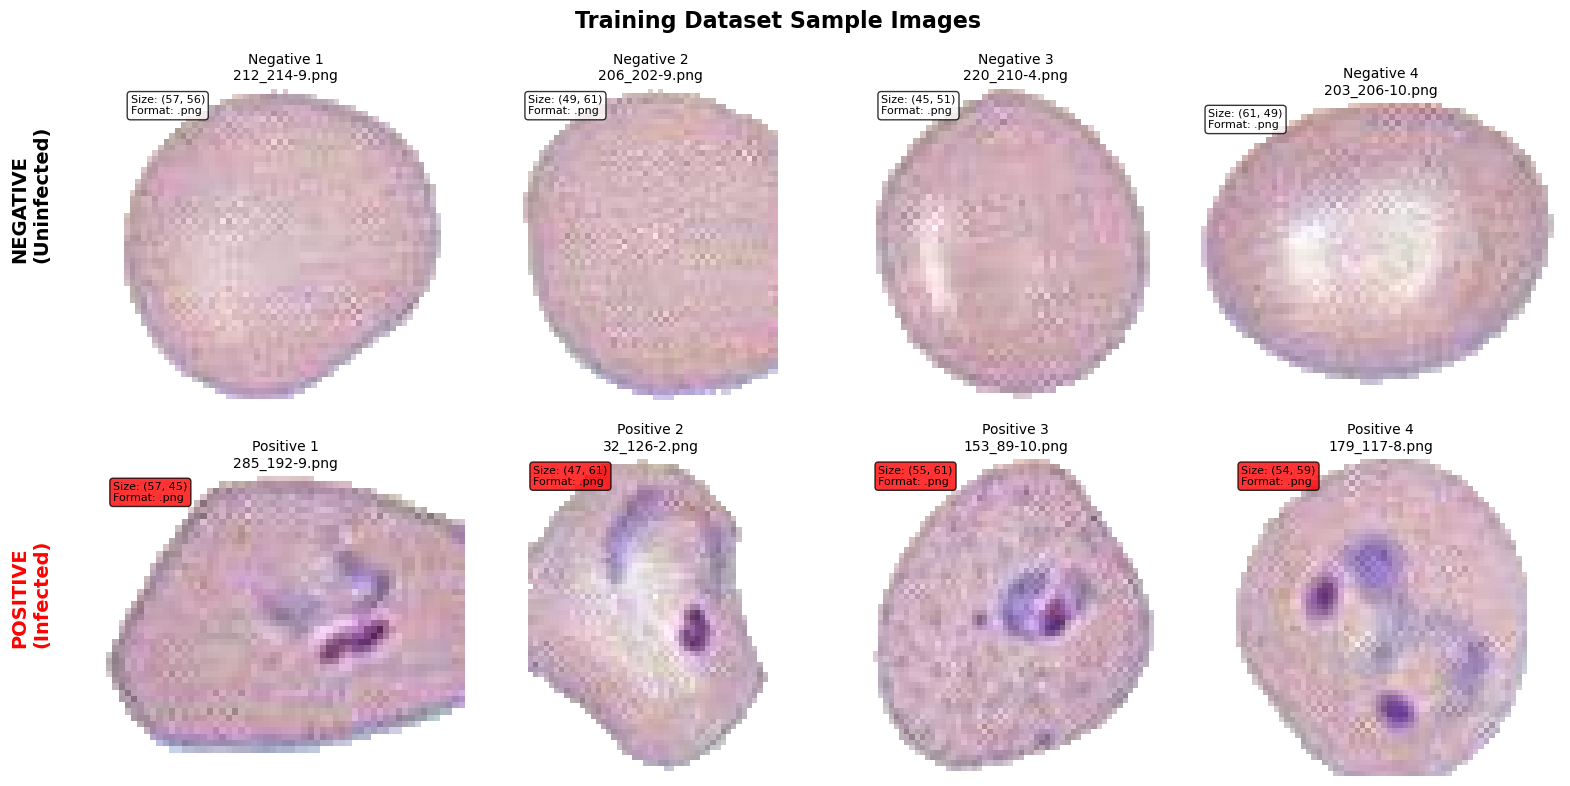

In [83]:
import random

def get_random_image_files(directory, num_samples=4):
    """Get random PNG image files from a directory"""
    image_extension = '.png'
    
    # Get all PNG image files
    image_files = []
    if directory.exists():
        for file_path in directory.iterdir():
            if file_path.is_file() and file_path.suffix.lower() == image_extension:
                image_files.append(file_path)
    
    # Return random sample
    if len(image_files) >= num_samples:
        return random.sample(image_files, num_samples)
    else:
        return image_files

# Function to visualize sample images
def visualize_training_samples():
    """Visualize sample images from training dataset"""
    
    # Get random samples
    negative_samples = get_random_image_files(TRAIN_NEGATIVE, 4)
    positive_samples = get_random_image_files(TRAIN_POSITIVE, 4)
    
    # Create figure with 2 rows and 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Training Dataset Sample Images', fontsize=16, fontweight='bold')
    
    # Plot negative samples (top row)
    for i, img_path in enumerate(negative_samples):
        try:
            img = Image.open(img_path)
            axes[0, i].imshow(img)
            axes[0, i].set_title(f'Negative {i+1}\n{img_path.name}', fontsize=10)
            axes[0, i].axis('off')
            
            # Add image info
            axes[0, i].text(0.02, 0.98, f'Size: {img.size}\nFormat: {img_path.suffix}', 
                           transform=axes[0, i].transAxes, fontsize=8, 
                           verticalalignment='top', bbox=dict(boxstyle='round', 
                           facecolor='white', alpha=0.8))
        except Exception as e:
            axes[0, i].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[0, i].axis('off')
    
    # Plot positive samples (bottom row)
    for i, img_path in enumerate(positive_samples):
        try:
            img = Image.open(img_path)
            axes[1, i].imshow(img)
            axes[1, i].set_title(f'Positive {i+1}\n{img_path.name}', fontsize=10)
            axes[1, i].axis('off')
            
            # Add image info
            axes[1, i].text(0.02, 0.98, f'Size: {img.size}\nFormat: {img_path.suffix}', 
                           transform=axes[1, i].transAxes, fontsize=8, 
                           verticalalignment='top', bbox=dict(boxstyle='round', 
                           facecolor='red', alpha=0.8))
        except Exception as e:
            axes[1, i].text(0.5, 0.5, f'Error loading\n{img_path.name}', 
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].axis('off')
    
    # Add row labels
    fig.text(0.02, 0.75, 'NEGATIVE\n(Uninfected)', fontsize=14, fontweight='bold', 
             rotation=90, verticalalignment='center')
    fig.text(0.02, 0.25, 'POSITIVE\n(Infected)', fontsize=14, fontweight='bold', 
             rotation=90, verticalalignment='center', color='red')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)  # Make room for labels
    plt.show()

# Set random seed for reproducible results
random.seed(42)

# Visualize the samples
visualize_training_samples()


# Verifying Image Dimensions

Consistent image dimensions are essential for proper processing because each pixel position must correspond across all samples. When images differ in width or height, the model cannot align pixel locations or form uniform tensors, causing shape mismatches and disrupting feature extraction. Standardizing the dimensions ensures that every image maps to the same spatial structure, allowing pixel-wise operations, batching, and neural network computations to function correctly.

Total PNG images analyzed: 7365
Unique sizes found: 1024
Smallest dimensions: 30x32 pixels
Largest dimensions: 67x86 pixels


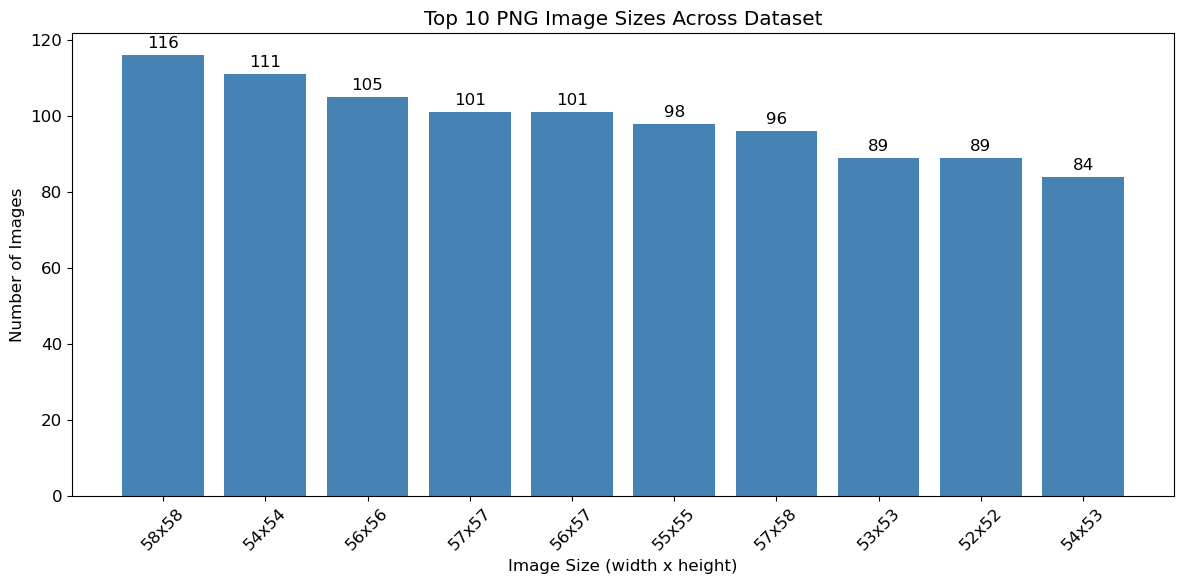

In [84]:
# Analyze PNG image dimensions across the dataset

def get_png_sizes(directory):
    """Return a list of (width, height) tuples for PNG files in a directory."""
    sizes = []
    if not directory.exists():
        print(f"Directory {directory} does not exist")
        return sizes
    
    for file_path in directory.glob('*.png'):
        if file_path.is_file():
            try:
                with Image.open(file_path) as img:
                    sizes.append(img.size)
            except Exception as e:
                print(f"  ✗ Could not read {file_path.name}: {e}")
    return sizes

overall_size_counter = Counter()

for _, dir_path in directories:
    sizes = get_png_sizes(dir_path)
    size_counts = Counter(sizes)
    overall_size_counter.update(size_counts)

print(f"Total PNG images analyzed: {sum(overall_size_counter.values())}")
print(f"Unique sizes found: {len(overall_size_counter)}")

if overall_size_counter:
    smallest_size = min(overall_size_counter.keys(), key=lambda s: s[0] * s[1])
    largest_size = max(overall_size_counter.keys(), key=lambda s: s[0] * s[1])
    print(f"Smallest dimensions: {smallest_size[0]}x{smallest_size[1]} pixels")
    print(f"Largest dimensions: {largest_size[0]}x{largest_size[1]} pixels")
    
    top_sizes = overall_size_counter.most_common(10)
    labels = [f"{w}x{h}" for (w, h), _ in top_sizes]
    counts = [count for _, count in top_sizes]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(labels, counts, color='steelblue')
    ax.set_title('Top 10 PNG Image Sizes Across Dataset')
    ax.set_xlabel('Image Size (width x height)')
    ax.set_ylabel('Number of Images')
    ax.bar_label(bars, labels=[str(c) for c in counts], padding=3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No PNG images found for size analysis.")


# Why 64×64 Is the Ideal Resolution for This Dataset

A target input resolution of 64×64 is selected to balance feature preservation and computational efficiency. The dataset’s dimensions cluster around ~55 px, ranging from 30×32 to 67×86. Using a standard size like 224×224 would require extreme upscaling—up to 700% for the smallest images—introducing interpolation artifacts that can obscure parasite features. In contrast, 64×64 is the closest power-of-two resolution that fits the dataset’s natural scale: larger images downsample cleanly with minimal loss, while smaller images undergo only mild, non-destructive upscaling. This maintains critical morphological details across the full distribution.

# Standardizing Malaria Images to 64 × 64 Pixels

### Why Cropping or Resizing Alone Doesn’t Work

For the malaria dataset, converting all images to 64×64 cannot be achieved through cropping or direct resizing. Cropping may remove the parasite at the cell’s edge, and resizing distorts the aspect ratio, altering critical cell morphology.

### Downsampling and Padding: Preserving Biological Structure

To preserve the biological structure, we first downsample the images. Downsampling reduces the image resolution while maintaining the overall spatial relationships and morphology, ensuring that the parasite remains intact. After downsampling, we pad the images to reach the target 64×64 size without stretching or compressing the cells. This sequence of downsampling first, then padding, preserves both the parasite features and the surrounding cell context.

### What Pixel Value Is Best for Padding?
Selecting the appropriate padding value is crucial to prevent introducing artifacts. We will experiment with both zero-padding and padding using the image’s mean value.

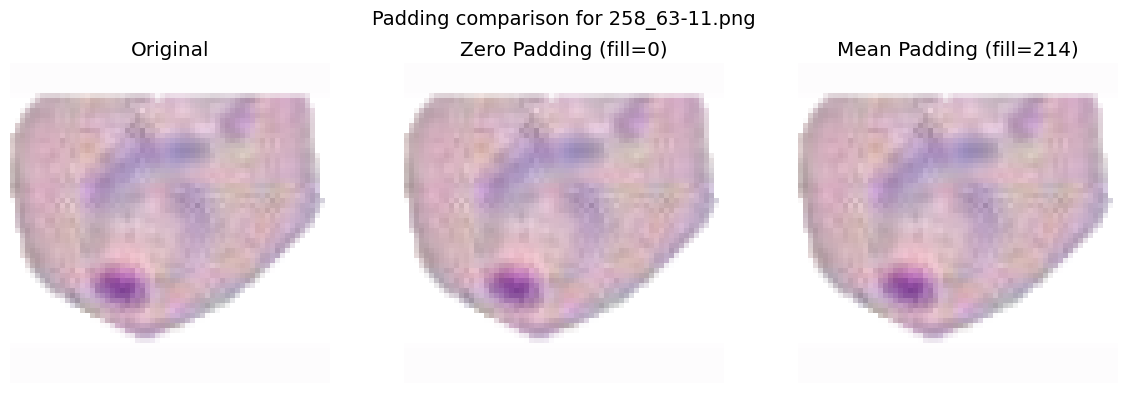

In [97]:
# Visualize padding strategies: zero padding vs. mean-color padding
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Sample positive image to illustrate padding
sample_image_path = TRAIN_POSITIVE / '258_63-11.png'
with Image.open(sample_image_path) as img:
    w, h = img.size
    max_wh = max(w, h)
    p_left, p_top = (max_wh - w) // 2, (max_wh - h) // 2
    p_right, p_bottom = max_wh - w - p_left, max_wh - h - p_top
    padding = (p_left, p_top, p_right, p_bottom)

    zero_padded = TF.pad(img, padding, fill=0)
    # Use mean pixel intensity as alternative padding color
    mean_value = int(np.mean(np.array(img)))
    mean_padded = TF.pad(img, padding, fill=mean_value)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(zero_padded)
axes[1].set_title('Zero Padding (fill=0)')
axes[1].axis('off')

axes[2].imshow(mean_padded)
axes[2].set_title(f'Mean Padding (fill={mean_value})')
axes[2].axis('off')

plt.suptitle(f"Padding comparison for {sample_image_path.name}", fontsize=14)
plt.tight_layout()
plt.show()

# Finding an Artifact-Free Padding Value

Initially, we tried standardizing image sizes using zero-padding and mean-padding. However, both approaches introduced unwanted artifacts:

- Zero-padding (black) created sharp, high-contrast borders that were unnatural for microscope images.

- Mean-padding produced visible gray bands, as the dark parasite pixels pulled the average downward, creating artificial edges.

These artifacts are problematic because the model could mistakenly learn to rely on them instead of focusing on true biological features.

To address this, we aim to identify a better universal padding value that blends seamlessly with the microscope background, preserving cell morphology while avoiding any misleading cues.

### Proposed solution
A more reliable approach analyzes 5×5 pixel blocks from the four corners of all images in the training dataset. Since the corners consistently contain empty microscope background, they provide an accurate estimate of the true slide color. Using this value for padding preserves the natural background while avoiding any misleading cues, ensuring the model focuses on genuine biological features.

In [93]:
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# CONFIGURATION
# Use your dataset path variable here
dataset_path = Path("malaria_dataset/train") 
all_images = list(dataset_path.rglob("*.png")) + list(dataset_path.rglob("*.tiff"))

print(f"Analyzing background color of {len(all_images)} images...")

r_totals, g_totals, b_totals = [], [], []

for img_path in tqdm(all_images):
    try:
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            arr = np.array(img)
            
            # STRATEGY: Sample 4 corners to be safe
            # (Top-Left, Top-Right, Bottom-Left, Bottom-Right)
            # We take small 5x5 chunks from each corner
            tl = arr[0:5, 0:5]
            tr = arr[0:5, -5:]
            bl = arr[-5:, 0:5]
            br = arr[-5:, -5:]
            
            # Combine all corner pixels
            corners = np.concatenate([tl, tr, bl, br])
            
            # Calculate average color for THIS image's background
            avg_color = np.mean(corners, axis=(0,1))
            
            r_totals.append(avg_color[0])
            g_totals.append(avg_color[1])
            b_totals.append(avg_color[2])
            
    except Exception as e:
        pass

# Calculate the GRAND AVERAGE across all images
final_r = int(np.mean(r_totals))
final_g = int(np.mean(g_totals))
final_b = int(np.mean(b_totals))

print("RESULTS: HARDCODE THESE VALUES")
print(f"Universal Background Color: ({final_r}, {final_g}, {final_b})")


Analyzing background color of 4800 images...


100%|██████████| 4800/4800 [00:00<00:00, 5224.89it/s]

RESULTS: HARDCODE THESE VALUES
Universal Background Color: (253, 253, 253)


# Universal Background Color

From this analysis, a “universal background color” (approximately 253, 252, 253) is obtained. Using this value for padding makes the padded regions visually seamless, ensuring the model concentrates only on the parasitic infection rather than on unnatural padding borders.

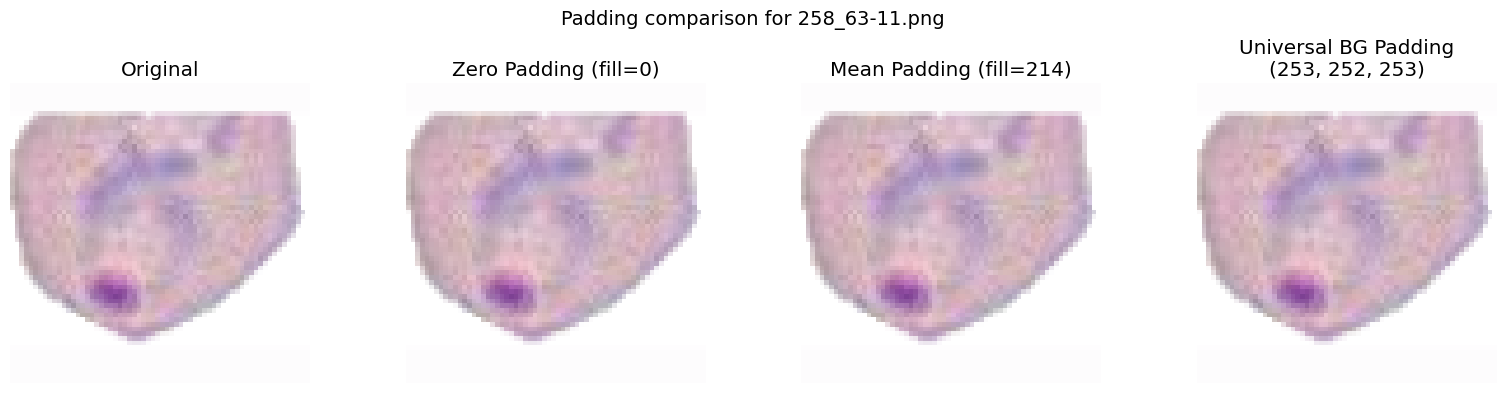

In [94]:
# Visualize padding strategies: zero padding vs. mean-color padding
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Sample positive image to illustrate padding
sample_image_path = TRAIN_POSITIVE / '258_63-11.png'
with Image.open(sample_image_path) as img:
    w, h = img.size
    max_wh = max(w, h)
    p_left, p_top = (max_wh - w) // 2, (max_wh - h) // 2
    p_right, p_bottom = max_wh - w - p_left, max_wh - h - p_top
    padding = (p_left, p_top, p_right, p_bottom)

    zero_padded = TF.pad(img, padding, fill=0)
    # Use mean pixel intensity as alternative padding color
    mean_value = int(np.mean(np.array(img)))
    mean_padded = TF.pad(img, padding, fill=mean_value)
    # Use universal background color computed from all images
    universal_bg = (253, 252, 253)
    universal_padded = TF.pad(img, padding, fill=universal_bg)

# Plot comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(zero_padded)
axes[1].set_title('Zero Padding (fill=0)')
axes[1].axis('off')

axes[2].imshow(mean_padded)
axes[2].set_title(f'Mean Padding (fill={mean_value})')
axes[2].axis('off')

axes[3].imshow(universal_padded)
axes[3].set_title(f'Universal BG Padding\n{universal_bg}')
axes[3].axis('off')

plt.suptitle(f"Padding comparison for {sample_image_path.name}", fontsize=14)
plt.tight_layout()
plt.show()

# Artifact-Free Padding with Universal Background Color

The results show that using the universal background color (253, 252, 253) for padding introduces no visible artifacts, unlike zero-padding or mean-padding, which create high-contrast edges or gray bands. Given its seamless integration with the microscope background, we will use this universal background color as the standard padding value for all images.

In [95]:
# Transform all images in-place to 64x64 using padding + resize
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as TF

class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        p_left, p_top = (max_wh - w) // 2, (max_wh - h) // 2
        p_right, p_bottom = max_wh - w - p_left, max_wh - h - p_top
        padding = (p_left, p_top, p_right, p_bottom)

        # Use universal background color computed from all images
        universal_bg = (253, 252, 253)
        return TF.pad(image, padding, fill=universal_bg)

transform = transforms.Compose([
    SquarePad(),
    transforms.Resize((64, 64))
])

for split_name, split_dir in [('train', TRAIN_PATH), ('val', VAL_PATH)]:
    for class_name in ['negative', 'positive']:
        src_dir = split_dir / class_name
        for img_path in src_dir.glob('*.png'):
            with Image.open(img_path) as img:
                img_resized = transform(img)
                img_resized.save(img_path)

print('All images have been transformed in-place to 64x64.')

All images have been transformed in-place to 64x64.


## Fix for the Class imbalance (Data Augmentation)

Given the significant class imbalance where negative samples (4,000) vastly outnumber positive samples (800), applying data augmentation exclusively to the positive class is the optimal strategy to prevent the model from blindly predicting "Negative" to achieve high accuracy. To establish perfect class parity, we calculated a required expansion factor of 5 (4000 / 800 = 5), which dictates that for every single original positive image, we must generate exactly four unique synthetic copies to reach a balanced total (800 original + (800 x 4 copies) = 4,000). We specifically selected Rotate 90°, Rotate 180°, Vertical Flip, and Horizontal Flip because these rigid geometric transformations are mathematically lossless and biologically "safe"; unlike random rotations or blurring which introduce interpolation artifacts, these operations preserve the exact pixel sharpness and diagnostic color integrity of the parasites while leveraging the fact that blood cells are rotation-invariant, ensuring the model learns to recognize the infection regardless of its orientation without the risk of degrading the image quality.

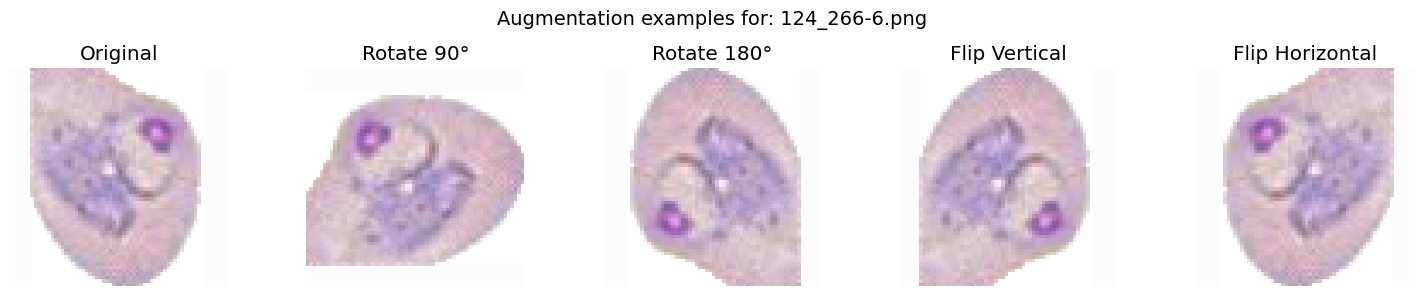

In [96]:
# Demonstrate simple augmentations on a random positive training image
import random
from PIL import Image
import matplotlib.pyplot as plt

# Pick a random positive sample
sample_path = random.choice(list(TRAIN_POSITIVE.glob('*.png')))
original_img = Image.open(sample_path)

# Apply requested augmentations
augmentations = {
    'Original': original_img,
    'Rotate 90°': original_img.rotate(90, expand=True),
    'Rotate 180°': original_img.rotate(180, expand=True),
    'Flip Vertical': original_img.transpose(Image.FLIP_TOP_BOTTOM),
    'Flip Horizontal': original_img.transpose(Image.FLIP_LEFT_RIGHT)
}

# Plot results
plt.figure(figsize=(15, 3))
for idx, (label, img) in enumerate(augmentations.items()):
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.suptitle(f"Augmentation examples for: {sample_path.name}", fontsize=14)
plt.tight_layout()
plt.show()


# The Limitation of Traditional ML for Image Data
While algorithms like Logistic Regression, Support Vector Machines (SVM), and Random Forests can serve as a useful baseline (a minimum score to beat), they are fundamentally flawed for complex image classification tasks like malaria detection. The primary reason is the destructive process of Flattening.

To feed a 64×64 pixel color image into these models, we must transform the 3D matrix (64 height × 64 width × 3 channels) into a massive 1D list of 12,288 individual numbers (64 x 64 x 3 = 12,288).

## Data Loading and Normalization

The dataset is already organized into `train/` and `val/` folders. In this section, we will:
1. **Load images** from the existing train and validation directories
2. **Normalize pixel values** to [0, 1] range (divide by 255) - this is crucial for neural network training because neural networks initialize weights with small random numbers, feeding in large integers (0-255) creates massive mathematical variance that destabilizes the gradients, whereas a small 0-1 range creates a smooth error landscape that allows the optimizer to converge significantly faster.
3. **Create labels** (0 for negative/uninfected, 1 for positive/infected)
4. **Combine data** into NumPy arrays ready for modeling

**Note:** We use the existing train/val split provided in the dataset - no need to reorganize folders!

### Step 1: Create Image Loading and Normalization Function

We'll create a reusable function that:
- Loads images from a directory
- Converts them to NumPy arrays
- Normalizes pixel values from [0, 255] to [0, 1] by dividing by 255
- Returns both the image arrays and corresponding labels


In [98]:
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

def load_images_from_directory(directory, label, target_size=(64, 64)):
    """
    Load and normalize images from a directory.
    
    Args:
        directory: Path to directory containing images
        label: Integer label for these images (0 for negative, 1 for positive)
        target_size: Expected image size (default: 64x64)
    
    Returns:
        images: NumPy array of shape (n_images, height, width, channels) with values in [0, 1]
        labels: NumPy array of shape (n_images,) with the label for each image
    """
    image_paths = list(directory.glob('*.png'))
    images = []
    labels = []
    
    print(f"Loading {len(image_paths)} images from {directory.name}...")
    
    for img_path in tqdm(image_paths, desc=f"Loading {directory.name}"):
        try:
            # Load image
            with Image.open(img_path) as img:
                # Ensure RGB format
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Convert to NumPy array
                img_array = np.array(img, dtype=np.float32)
                
                # Verify size (should be 64x64 after preprocessing)
                if img_array.shape[:2] != target_size:
                    print(f"Warning: {img_path.name} has size {img_array.shape[:2]}, expected {target_size}")
                
                # Normalize to [0, 1] by dividing by 255
                img_normalized = img_array / 255.0
                
                images.append(img_normalized)
                labels.append(label)
                
        except Exception as e:
            print(f"Error loading {img_path.name}: {e}")
            continue
    
    return np.array(images), np.array(labels)

print("Image loading function created successfully!")


Image loading function created successfully!


### Step 2: Load Training and Validation Data

Now we'll load all images from both training and validation sets, creating separate arrays for each split.


In [99]:
# Load training data
print("=" * 60)
print("LOADING TRAINING DATA")
print("=" * 60)

train_neg_images, train_neg_labels = load_images_from_directory(
    TRAIN_NEGATIVE, 
    label=0  # 0 = negative/uninfected
)

train_pos_images, train_pos_labels = load_images_from_directory(
    TRAIN_POSITIVE, 
    label=1  # 1 = positive/infected
)

# Combine training data
X_train = np.concatenate([train_neg_images, train_pos_images], axis=0)
y_train = np.concatenate([train_neg_labels, train_pos_labels], axis=0)

print(f"\nTraining data loaded:")
print(f"  Total images: {len(X_train)}")
print(f"  Negative samples: {np.sum(y_train == 0)}")
print(f"  Positive samples: {np.sum(y_train == 1)}")

# Load validation data
print("\n" + "=" * 60)
print("LOADING VALIDATION DATA")
print("=" * 60)

val_neg_images, val_neg_labels = load_images_from_directory(
    VAL_NEGATIVE, 
    label=0
)

val_pos_images, val_pos_labels = load_images_from_directory(
    VAL_POSITIVE, 
    label=1
)

# Combine validation data
X_val = np.concatenate([val_neg_images, val_pos_images], axis=0)
y_val = np.concatenate([val_neg_labels, val_pos_labels], axis=0)

print(f"\nValidation data loaded:")
print(f"  Total images: {len(X_val)}")
print(f"  Negative samples: {np.sum(y_val == 0)}")
print(f"  Positive samples: {np.sum(y_val == 1)}")


LOADING TRAINING DATA
Loading 4000 images from negative...


Loading negative: 100%|██████████| 4000/4000 [00:00<00:00, 4320.63it/s]


Loading 800 images from positive...


Loading positive: 100%|██████████| 800/800 [00:00<00:00, 5078.60it/s]



Training data loaded:
  Total images: 4800
  Negative samples: 4000
  Positive samples: 800

LOADING VALIDATION DATA
Loading 1531 images from negative...


Loading negative: 100%|██████████| 1531/1531 [00:00<00:00, 5188.29it/s]


Loading 1034 images from positive...


Loading positive: 100%|██████████| 1034/1034 [00:00<00:00, 4721.14it/s]


Validation data loaded:
  Total images: 2565
  Negative samples: 1531
  Positive samples: 1034


### Step 3: Verify Normalization

We need to confirm that all pixel values are in the [0, 1] range. This is critical for neural network training.


In [100]:
# Verify normalization for training data
print("NORMALIZATION VERIFICATION - Training Data")
print("=" * 60)

train_min = X_train.min()
train_max = X_train.max()
train_mean = X_train.mean()
train_std = X_train.std()

print(f"Pixel value range: [{train_min:.6f}, {train_max:.6f}]")
print(f"Mean pixel value: {train_mean:.6f}")
print(f"Standard deviation: {train_std:.6f}")

# Check if all values are in [0, 1]
if train_min >= 0.0 and train_max <= 1.0:
    print("✓ All pixel values are in [0, 1] range - Normalization successful!")
else:
    print("✗ WARNING: Some pixel values are outside [0, 1] range!")
    print(f"  Values below 0: {np.sum(X_train < 0)}")
    print(f"  Values above 1: {np.sum(X_train > 1)}")

# Verify normalization for validation data
print("\nNORMALIZATION VERIFICATION - Validation Data")
print("=" * 60)

val_min = X_val.min()
val_max = X_val.max()
val_mean = X_val.mean()
val_std = X_val.std()

print(f"Pixel value range: [{val_min:.6f}, {val_max:.6f}]")
print(f"Mean pixel value: {val_mean:.6f}")
print(f"Standard deviation: {val_std:.6f}")

# Check if all values are in [0, 1]
if val_min >= 0.0 and val_max <= 1.0:
    print("✓ All pixel values are in [0, 1] range - Normalization successful!")
else:
    print("✗ WARNING: Some pixel values are outside [0, 1] range!")
    print(f"  Values below 0: {np.sum(X_val < 0)}")
    print(f"  Values above 1: {np.sum(X_val > 1)}")


NORMALIZATION VERIFICATION - Training Data
Pixel value range: [0.058824, 1.000000]
Mean pixel value: 0.814475
Standard deviation: 0.133258
✓ All pixel values are in [0, 1] range - Normalization successful!

NORMALIZATION VERIFICATION - Validation Data
Pixel value range: [0.031373, 1.000000]
Mean pixel value: 0.806585
Standard deviation: 0.152727
✓ All pixel values are in [0, 1] range - Normalization successful!


### Step 4: Display Data Shapes and Class Distributions

Understanding the data structure is essential before modeling. We'll examine:
- **Data shapes**: Dimensions of our arrays
- **Class distributions**: Balance/imbalance in each split
- **Memory usage**: How much RAM our data requires


DATA SHAPES
Training images (X_train): (4800, 64, 64, 3)
  - Format: (n_samples, height, width, channels)
  - Samples: 4800
  - Image size: 64x64 pixels
  - Channels: 3 (RGB)

Training labels (y_train): (4800,)
  - Format: (n_samples,)

Validation images (X_val): (2565, 64, 64, 3)
Validation labels (y_val): (2565,)

MEMORY USAGE
Training data: 225.00 MB
Validation data: 120.23 MB
Total: 345.23 MB

CLASS DISTRIBUTIONS
Training Set:
  Negative (Uninfected): 4000 (83.3%)
  Positive (Infected): 800 (16.7%)
  Total: 4800
  Class ratio (Neg:Pos): 4000:800 = 5.00:1

Validation Set:
  Negative (Uninfected): 1531 (59.7%)
  Positive (Infected): 1034 (40.3%)
  Total: 2565
  Class ratio (Neg:Pos): 1531:1034 = 1.48:1


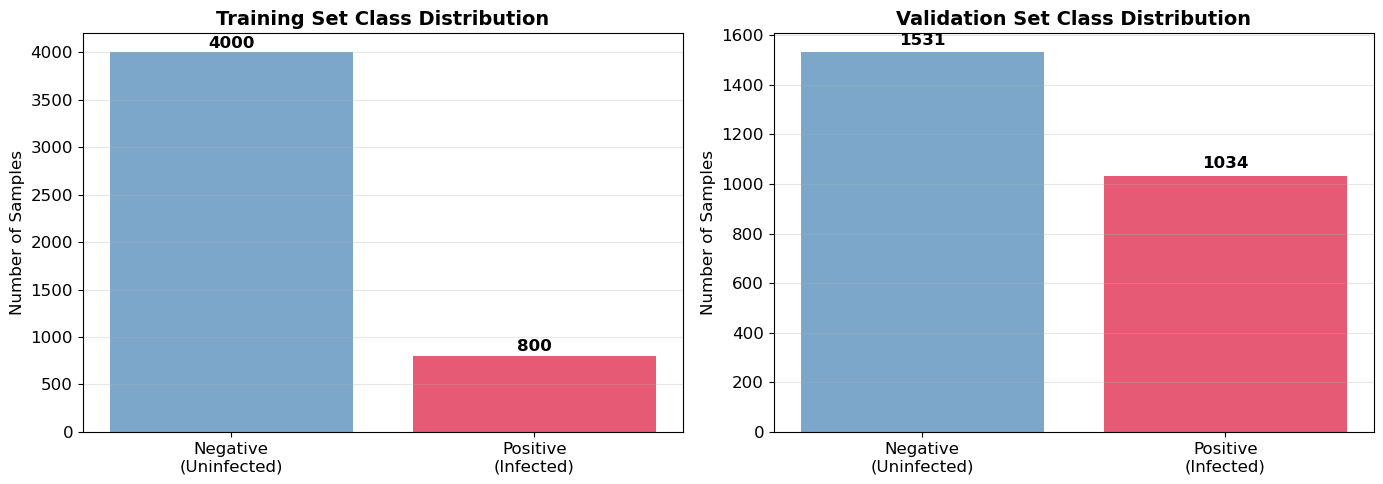


✓ Data loading and verification complete!
  Ready for model training!


In [101]:
# Display data shapes
print("DATA SHAPES")
print("=" * 60)
print(f"Training images (X_train): {X_train.shape}")
print(f"  - Format: (n_samples, height, width, channels)")
print(f"  - Samples: {X_train.shape[0]}")
print(f"  - Image size: {X_train.shape[1]}x{X_train.shape[2]} pixels")
print(f"  - Channels: {X_train.shape[3]} (RGB)")

print(f"\nTraining labels (y_train): {y_train.shape}")
print(f"  - Format: (n_samples,)")

print(f"\nValidation images (X_val): {X_val.shape}")
print(f"Validation labels (y_val): {y_val.shape}")

# Calculate memory usage
train_size_mb = X_train.nbytes / (1024 * 1024)
val_size_mb = X_val.nbytes / (1024 * 1024)
total_size_mb = train_size_mb + val_size_mb

print(f"\nMEMORY USAGE")
print("=" * 60)
print(f"Training data: {train_size_mb:.2f} MB")
print(f"Validation data: {val_size_mb:.2f} MB")
print(f"Total: {total_size_mb:.2f} MB")

# Display class distributions
print(f"\nCLASS DISTRIBUTIONS")
print("=" * 60)

# Training set
train_neg_count = np.sum(y_train == 0)
train_pos_count = np.sum(y_train == 1)
train_total = len(y_train)

print("Training Set:")
print(f"  Negative (Uninfected): {train_neg_count} ({100*train_neg_count/train_total:.1f}%)")
print(f"  Positive (Infected): {train_pos_count} ({100*train_pos_count/train_total:.1f}%)")
print(f"  Total: {train_total}")
print(f"  Class ratio (Neg:Pos): {train_neg_count}:{train_pos_count} = {train_neg_count/train_pos_count:.2f}:1")

# Validation set
val_neg_count = np.sum(y_val == 0)
val_pos_count = np.sum(y_val == 1)
val_total = len(y_val)

print("\nValidation Set:")
print(f"  Negative (Uninfected): {val_neg_count} ({100*val_neg_count/val_total:.1f}%)")
print(f"  Positive (Infected): {val_pos_count} ({100*val_pos_count/val_total:.1f}%)")
print(f"  Total: {val_total}")
print(f"  Class ratio (Neg:Pos): {val_neg_count}:{val_pos_count} = {val_neg_count/val_pos_count:.2f}:1")

# Visualize class distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = [train_neg_count, train_pos_count]
axes[0].bar(['Negative\n(Uninfected)', 'Positive\n(Infected)'], train_counts, 
            color=['steelblue', 'crimson'], alpha=0.7)
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', alpha=0.3)
for i, count in enumerate(train_counts):
    axes[0].text(i, count + 50, str(count), ha='center', fontweight='bold')

# Validation set distribution
val_counts = [val_neg_count, val_pos_count]
axes[1].bar(['Negative\n(Uninfected)', 'Positive\n(Infected)'], val_counts,
            color=['steelblue', 'crimson'], alpha=0.7)
axes[1].set_title('Validation Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Samples')
axes[1].grid(axis='y', alpha=0.3)
for i, count in enumerate(val_counts):
    axes[1].text(i, count + 30, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Data loading and verification complete!")
print("  Ready for model training!")


## Convolutional Neural Network (CNN) for Malaria Detection

We'll build a CNN from scratch to classify malaria-infected vs uninfected blood cells. This approach is superior to traditional ML because:
- **Preserves spatial information**: Convolutional layers learn spatial patterns (edges, shapes, textures)
- **Hierarchical feature learning**: Automatically learns low-level (edges) to high-level (parasite shapes) features
- **Translation invariance**: Can detect parasites regardless of their position in the image

### Strategy:
1. **Data Augmentation**: Apply rotations and flips to positive samples during training to balance classes (4000:4000)
2. **CNN Architecture**: Build a simple but effective CNN with convolutional, pooling, and dense layers
3. **Training with Validation**: Monitor validation metrics during training


In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Step 1: Data Augmentation for Positive Class

We'll augment the positive training samples using the same transformations we demonstrated earlier (rotations and flips) to balance the classes from 5:1 to approximately 1:1.


In [103]:
# Data Augmentation: Create augmented positive samples to balance classes
print("=" * 60)
print("DATA AUGMENTATION - Balancing Classes")
print("=" * 60)

# Separate positive and negative training samples
train_pos_indices = np.where(y_train == 1)[0]
train_neg_indices = np.where(y_train == 0)[0]

train_pos_images = X_train[train_pos_indices]
train_neg_images = X_train[train_neg_indices]

print(f"Original training data:")
print(f"  Negative samples: {len(train_neg_images)}")
print(f"  Positive samples: {len(train_pos_images)}")
print(f"  Ratio: {len(train_neg_images) / len(train_pos_images):.2f}:1")

# We need 4 augmented copies per positive image to reach ~4000 positive samples
# (800 original + 4*800 = 3200 augmented = 4000 total)
augmentations_per_image = 4
augmented_pos_images = []
augmented_pos_labels = []

print(f"\nGenerating {augmentations_per_image} augmented copies per positive image...")

for img in tqdm(train_pos_images, desc="Augmenting positive samples"):
    # Convert back to PIL Image for augmentation
    img_pil = Image.fromarray((img * 255).astype(np.uint8))
    
    # Apply 4 augmentations: 90° rotation, 180° rotation, vertical flip, horizontal flip
    aug1 = img_pil.rotate(90, expand=True)  # Rotate 90°
    aug2 = img_pil.rotate(180, expand=True)  # Rotate 180°
    aug3 = img_pil.transpose(Image.FLIP_TOP_BOTTOM)  # Vertical flip
    aug4 = img_pil.transpose(Image.FLIP_LEFT_RIGHT)  # Horizontal flip
    
    # Convert back to numpy and normalize
    for aug_img in [aug1, aug2, aug3, aug4]:
        aug_array = np.array(aug_img.resize((64, 64)), dtype=np.float32) / 255.0
        augmented_pos_images.append(aug_array)
        augmented_pos_labels.append(1)

augmented_pos_images = np.array(augmented_pos_images)
augmented_pos_labels = np.array(augmented_pos_labels)

# Combine original and augmented positive samples
X_train_balanced_pos = np.concatenate([train_pos_images, augmented_pos_images], axis=0)
y_train_balanced_pos = np.concatenate([np.ones(len(train_pos_images)), augmented_pos_labels], axis=0)

# Combine with negative samples
X_train_balanced = np.concatenate([train_neg_images, X_train_balanced_pos], axis=0)
y_train_balanced = np.concatenate([np.zeros(len(train_neg_images)), y_train_balanced_pos], axis=0)

# Shuffle the balanced dataset
shuffle_indices = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[shuffle_indices]
y_train_balanced = y_train_balanced[shuffle_indices]

print(f"\nBalanced training data:")
print(f"  Negative samples: {np.sum(y_train_balanced == 0)}")
print(f"  Positive samples: {np.sum(y_train_balanced == 1)}")
print(f"  Total samples: {len(X_train_balanced)}")
print(f"  Ratio: {np.sum(y_train_balanced == 0) / np.sum(y_train_balanced == 1):.2f}:1")
print("✓ Data augmentation complete!")


DATA AUGMENTATION - Balancing Classes
Original training data:
  Negative samples: 4000
  Positive samples: 800
  Ratio: 5.00:1

Generating 4 augmented copies per positive image...


Augmenting positive samples: 100%|██████████| 800/800 [00:00<00:00, 10057.83it/s]



Balanced training data:
  Negative samples: 4000
  Positive samples: 4000
  Total samples: 8000
  Ratio: 1.00:1
✓ Data augmentation complete!


### Step 2: Define CNN Architecture

We'll build a CNN with:
- **Convolutional layers**: Extract spatial features (edges, textures, patterns)
- **Max pooling layers**: Reduce spatial dimensions and computational cost
- **Dropout layers**: Prevent overfitting
- **Dense layers**: Final classification


In [ ]:
# Define CNN Model Architecture
print("=" * 60)
print("BUILDING CNN MODEL")
print("=" * 60)

def create_cnn_model(input_shape=(64, 64, 3)):
    """
    Create a CNN model for binary malaria classification.
    
    Architecture:
    - Conv2D layers with increasing filters (32, 64, 128)
    - MaxPooling2D after each conv block
    - Dropout for regularization
    - Dense layers for classification
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25, name='dropout1'),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25, name='dropout2'),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.25, name='dropout3'),
        
        # Flatten and Dense Layers
        layers.Flatten(name='flatten'),
        layers.Dense(512, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout4'),
        layers.Dense(256, activation='relu', name='dense2'),
        layers.Dropout(0.5, name='dropout5'),
        
        # Output layer (binary classification)
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Create the model
model = create_cnn_model(input_shape=(64, 64, 3))

# Display model architecture
print("\nModel Architecture:")
print("=" * 60)
model.summary()

# Calculate total parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


BUILDING CNN MODEL


/opt/anaconda3/envs/env_ml_research/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-19 16:26:18.671334: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-11-19 16:26:18.671704: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-19 16:26:18.671712: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-19 16:26:18.672207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-19 16:26:18.672622: I tensorflow/core/common_runtime/pluggable_device/pluggable_dev


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,584,641 (9.86 MB)

 Trainable params: 2,584,641 (9.86 MB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 2,584,641
Trainable parameters: 2,584,641


### Step 3: Compile Model and Set Up Training

We'll use:
- **Binary crossentropy loss**: Standard for binary classification
- **Adam optimizer**: Adaptive learning rate
- **Callbacks**: Early stopping and learning rate reduction


In [ ]:
# Compile the model
print("=" * 60)
print("COMPILING MODEL")
print("=" * 60)

# Loss Function: Binary Crossentropy
# We use binary_crossentropy because:
# 1. This is a binary classification problem (infected vs uninfected)
# 2. Binary crossentropy measures the difference between predicted probabilities and true labels (0 or 1)
# 3. It works perfectly with sigmoid activation in the output layer (produces probabilities in [0, 1])
# 4. It penalizes confident wrong predictions more heavily, encouraging the model to be more accurate
# 5. It's the standard loss function for binary classification in medical/biological image classification tasks
# Formula: L = -(y * log(p) + (1-y) * log(1-p)) where y is true label and p is predicted probability

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary crossentropy for binary classification
    metrics=['accuracy', 'precision', 'recall']
)

print("✓ Model compiled successfully!")
print("  Optimizer: Adam (lr=0.001)")
print("  Loss: Binary Crossentropy")
print("  Metrics: Accuracy, Precision, Recall")

# Set up callbacks
# Callbacks are functions that are called during training at specific points (e.g., end of each epoch)
# They allow us to monitor training and make adjustments automatically

callbacks = [
    # EarlyStopping: Stops training early if the model stops improving
    # - monitor='val_accuracy': Watch the validation accuracy metric (better than val_loss for this problem)
    # - mode='max': We want to maximize accuracy (default is 'auto' which detects this automatically)
    # - patience=10: Wait 10 epochs without improvement before stopping
    # - restore_best_weights=True: Restore the model weights from the epoch with the best validation accuracy
    # - verbose=1: Print messages when early stopping is triggered
    # Purpose: Prevents overfitting and saves training time by stopping when model can't improve further
    # NOTE: Changed from 'val_loss' to 'val_accuracy' because val_loss can be misleading when model predicts all as one class
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # ReduceLROnPlateau: Reduces learning rate when the model stops improving
    # - monitor='val_loss': Watch the validation loss metric
    # - factor=0.5: Multiply learning rate by 0.5 (reduce by half) when triggered
    # - patience=5: Wait 5 epochs without improvement before reducing learning rate
    # - min_lr=1e-7: Don't reduce learning rate below this minimum value
    # - verbose=1: Print messages when learning rate is reduced
    # Purpose: Helps fine-tune the model by using smaller learning rates when stuck, allowing for more precise weight updates
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nCallbacks configured:")
print("  - EarlyStopping: Stop if val_loss doesn't improve for 10 epochs")
print("  - ReduceLROnPlateau: Reduce learning rate if val_loss plateaus")


COMPILING MODEL
✓ Model compiled successfully!
  Optimizer: Adam (lr=0.001)
  Loss: Binary Crossentropy
  Metrics: Accuracy, Precision, Recall

Callbacks configured:
  - EarlyStopping: Stop if val_loss doesn't improve for 10 epochs
  - ReduceLROnPlateau: Reduce learning rate if val_loss plateaus


### Step 4: Train the Model

We'll train the model and monitor validation metrics in real-time. The training will show:
- Training and validation loss
- Training and validation accuracy
- Training and validation precision
- Training and validation recall


In [106]:
# Train the model
print("=" * 60)
print("TRAINING CNN MODEL")
print("=" * 60)
print(f"Training samples: {len(X_train_balanced)}")
print(f"Validation samples: {len(X_val)}")
print(f"Batch size: 32")
print(f"Epochs: 50 (with early stopping)")
print("=" * 60)

# Train the model
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)


TRAINING CNN MODEL
Training samples: 8000
Validation samples: 2565
Batch size: 32
Epochs: 50 (with early stopping)
Epoch 1/50


2025-11-19 16:26:51.316725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5095 - loss: 0.8330 - precision: 0.5162 - recall: 0.3898 - val_accuracy: 0.5969 - val_loss: 0.6929 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5290 - loss: 0.6693 - precision: 0.5238 - recall: 0.4992 - val_accuracy: 0.9096 - val_loss: 2.3524 - val_precision: 0.8198 - val_recall: 0.9942 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9919 - loss: 0.0517 - precision: 0.9906 - recall: 0.9934 - val_accuracy: 0.9345 - val_loss: 4.9998 - val_precision: 0.8626 - val_recall: 0.9961 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9967 - loss: 0.0146 - precision: 0.9977 - recall: 0.9957 - val_accuracy: 0.9388 - val_loss: 6.8098 - val_precision: 0.8688 - val_recall: 0.9990 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accurac

### Step 5: Visualize Training History

Plot training and validation metrics to analyze model performance.


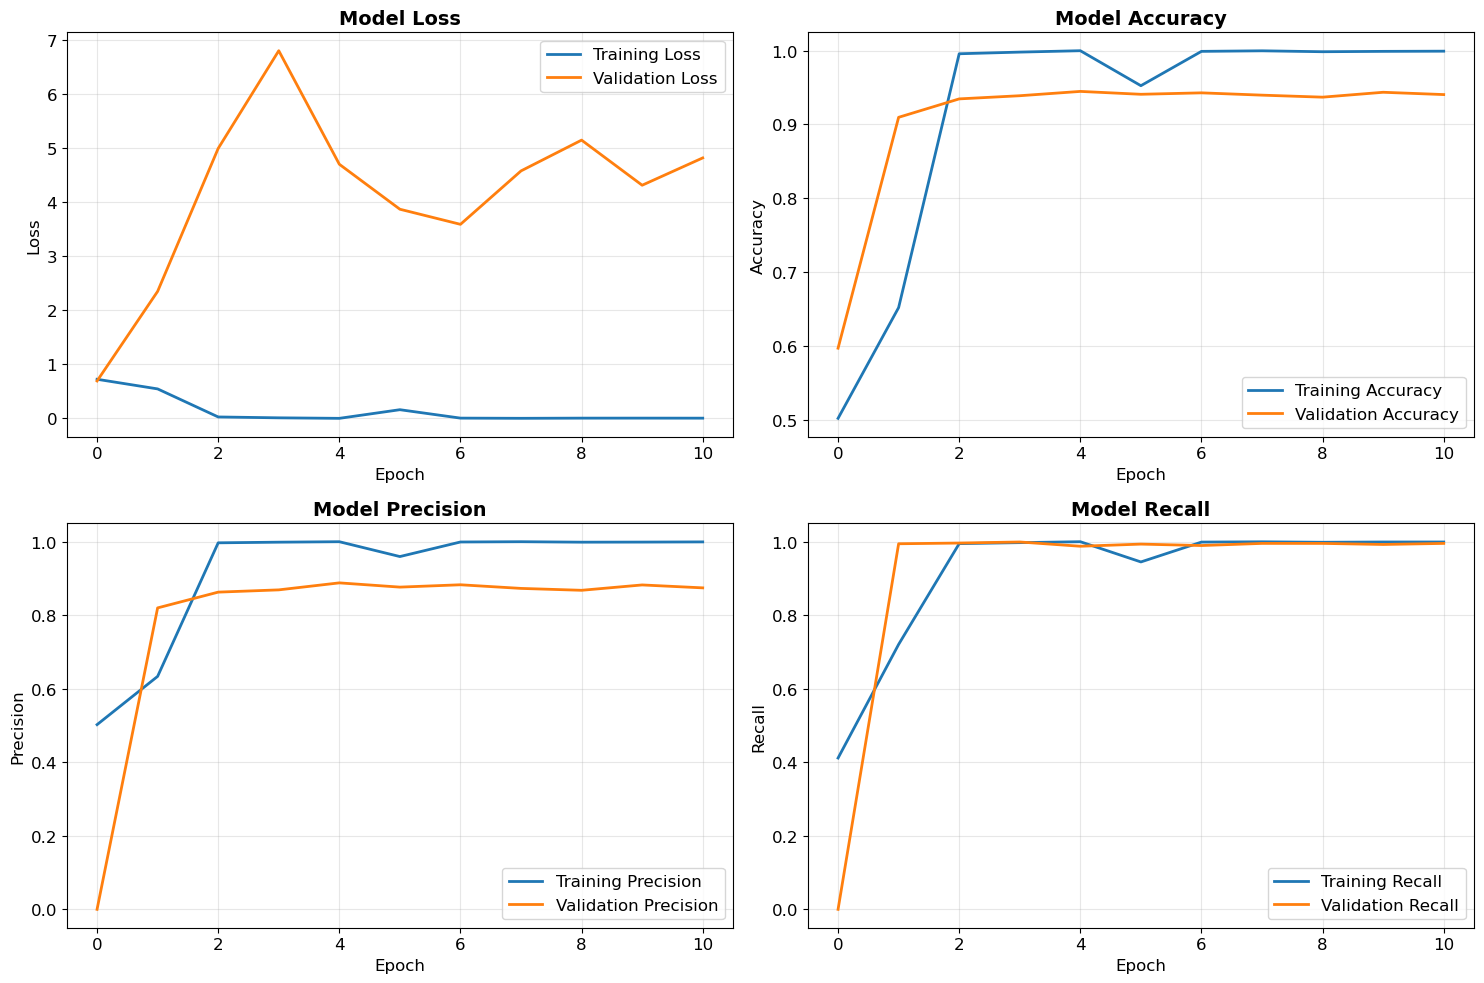

FINAL MODEL PERFORMANCE
Training Accuracy: 0.9991
Validation Accuracy: 0.9404
Training Precision: 0.9992
Validation Precision: 0.8743
Training Recall: 0.9990
Validation Recall: 0.9952


In [107]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("FINAL MODEL PERFORMANCE")
print("=" * 60)
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Training Precision: {history.history['precision'][-1]:.4f}")
print(f"Validation Precision: {history.history['val_precision'][-1]:.4f}")
print(f"Training Recall: {history.history['recall'][-1]:.4f}")
print(f"Validation Recall: {history.history['val_recall'][-1]:.4f}")


Model is overfitting. 
To reduce the severe overfitting (where Training Accuracy is 100% but Validation Loss is exploding), we need to restrict the model's "freedom" to memorize. Currently, the model is too complex for simple 64x64 images.

1. Drastically Reduce Dense Layer Size (The Main Culprit)
You are using 512 and 256 neurons in your dense layers.

Problem: This gives the model millions of parameters to memorize specific pixels of the training images.

Fix: Drop this to 64 or 128. Malaria parasites are simple shapes (blobs/rings); you don't need a massive "brain" to recognize them.

2. Add Batch Normalization
You are missing Batch Normalization.

Problem: Without it, color values shift around during training, making the model chase moving targets.

Fix: Add layers.BatchNormalization() after every Convolution and before the Activation. This stabilizes the model and has a regularizing effect.

3. Add L2 Regularization (Weight Decay)
Problem: Your model is "Arrogant" (predicting 0.9999 probability).

Fix: Add L2 Regularization. This penalizes the model for having huge weights, forcing it to be "humble" and smoother in its predictions.

## Back to Setp 2. We will again follow the step 2 to step 5.
Define a less complicated mode to reduce the overfitting.  

IMPROVED CNN MODEL - WITH BATCHNORM & L2 REGULARIZATION
Changes to reduce overfitting:
  - Added BatchNormalization after each Conv2D layer
  - Reduced Dense layer from 512 to 64 neurons
  - Added L2 regularization (0.001) to Dense layer
  - Removed second Dense(256) layer
  - Using padding='same' to preserve spatial dimensions

MODEL ARCHITECTURE


/opt/anaconda3/envs/env_ml_research/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,817 (2.36 MB)

 Trainable params: 618,241 (2.36 MB)

 Non-trainable params: 576 (2.25 KB)


COMPILING MODEL
✓ Model compiled successfully!
  Optimizer: Adam (lr=0.001)
  Loss: Binary Crossentropy
  Metrics: Accuracy, Precision, Recall

Callbacks configured:
  - EarlyStopping: Stop if val_accuracy doesn't improve for 10 epochs
  - ReduceLROnPlateau: Reduce learning rate if val_loss doesn't improve for 5 epochs

TRAINING IMPROVED CNN MODEL
Training samples: 8000
Validation samples: 2565
Batch size: 32
Epochs: 50 (with early stopping)
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9714 - loss: 0.2052 - precision: 0.9710 - recall: 0.9737 - val_accuracy: 0.5969 - val_loss: 2.6861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9989 - loss: 0.0638 - precision: 0.9990 - recall: 0.9989 - val_accuracy: 0.6347 - val_loss: 1.1904 - val_precision: 0.8880 - val_recall: 0.1074 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9987 - 

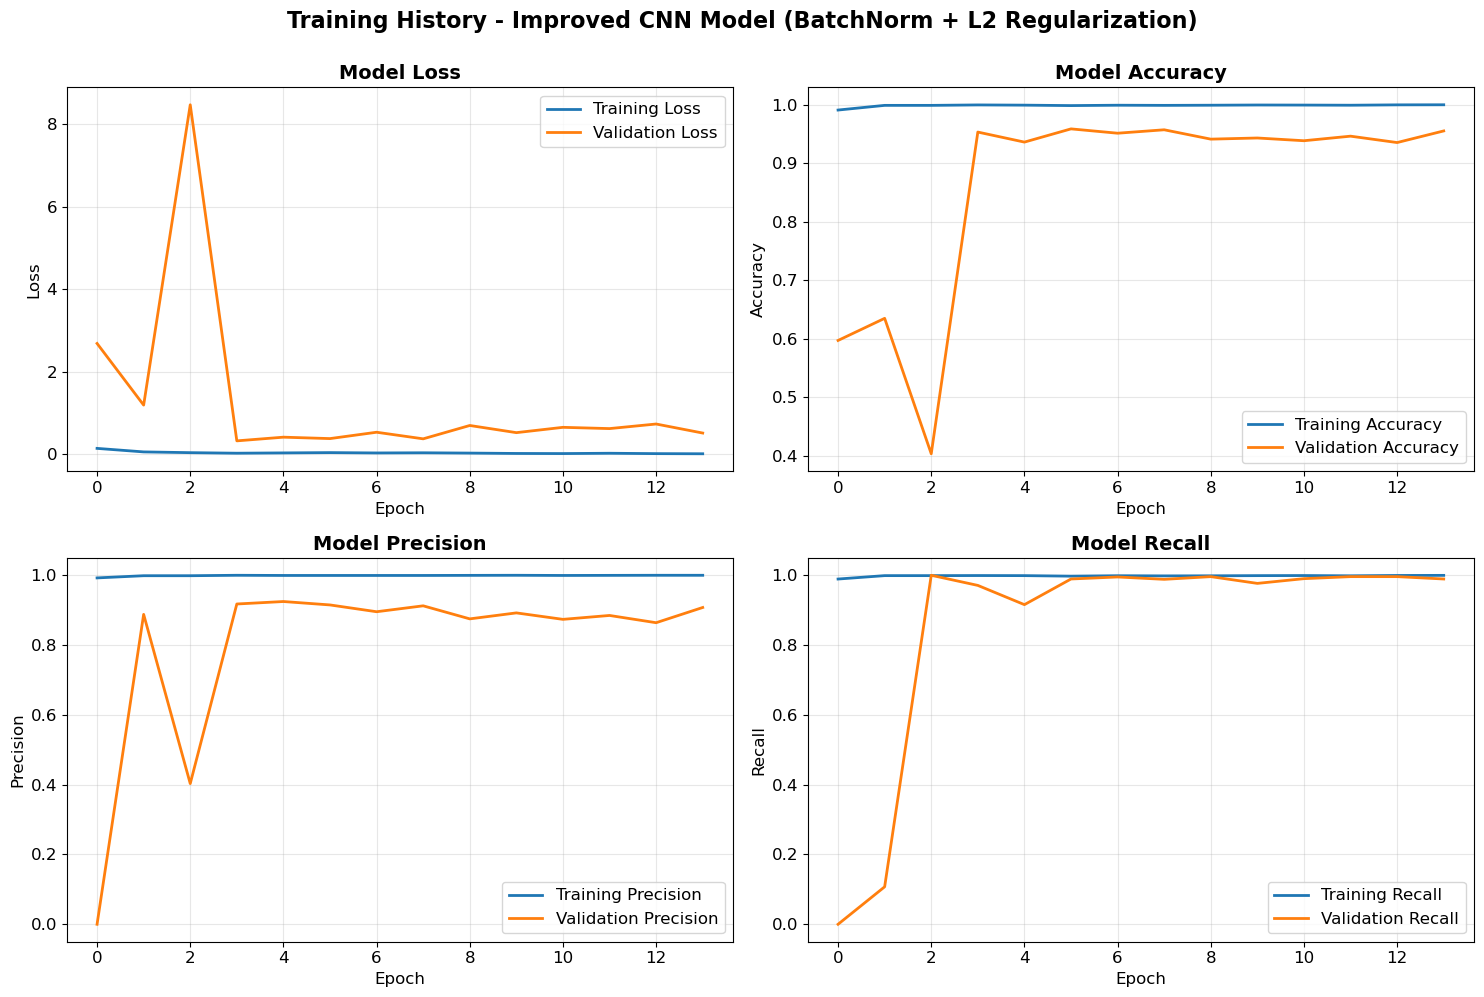

In [114]:
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score

print("=" * 60)
print("IMPROVED CNN MODEL - WITH BATCHNORM & L2 REGULARIZATION")
print("=" * 60)
print("Changes to reduce overfitting:")
print("  - Added BatchNormalization after each Conv2D layer")
print("  - Reduced Dense layer from 512 to 64 neurons")
print("  - Added L2 regularization (0.001) to Dense layer")
print("  - Removed second Dense(256) layer")
print("  - Using padding='same' to preserve spatial dimensions")
print("=" * 60)

def create_cnn_model(input_shape=(64, 64, 3)):
    """Improved CNN model with BatchNorm and L2 regularization to reduce overfitting."""
    model = models.Sequential([
        # --- Block 1 ---
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape, name='conv1'),
        layers.BatchNormalization(), 
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.2, name='dropout1'), # Reduced slightly, BatchNorm helps regularize
        
        # --- Block 2 ---
        layers.Conv2D(64, (3, 3), padding='same', name='conv2'),
        layers.BatchNormalization(), 
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.2, name='dropout2'),
        
        # --- Block 3 ---
        layers.Conv2D(128, (3, 3), padding='same', name='conv3'),
        layers.BatchNormalization(),  
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.3, name='dropout3'), # Increased dropout deeper in the network
        
        # --- Classification Head ---
        layers.Flatten(name='flatten'),
        
        # CHANGED: Reduced from 512 to 64! Added L2 Regularization
        layers.Dense(64, name='dense1', 
                     kernel_regularizer=regularizers.l2(0.001)), 
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5, name='dropout4'),
        
        # REMOVED the second Dense(256) layer entirely. It was unnecessary.
        
        # Output layer
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Create the improved model
model = create_cnn_model(input_shape=(64, 64, 3))

# Display model architecture
print("\n" + "=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
model.summary()

# Compile the model
print("\n" + "=" * 60)
print("COMPILING MODEL")
print("=" * 60)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("✓ Model compiled successfully!")
print("  Optimizer: Adam (lr=0.001)")
print("  Loss: Binary Crossentropy")
print("  Metrics: Accuracy, Precision, Recall")

# Set up callbacks
# Callbacks are functions that are called during training at specific points (e.g., end of each epoch)
# They allow us to monitor training and make adjustments automatically

callbacks = [
  
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nCallbacks configured:")
print("  - EarlyStopping: Stop if val_accuracy doesn't improve for 10 epochs")
print("  - ReduceLROnPlateau: Reduce learning rate if val_loss doesn't improve for 5 epochs")

# Train the model
print("\n" + "=" * 60)
print("TRAINING IMPROVED CNN MODEL")
print("=" * 60)
print(f"Training samples: {len(X_train_balanced)}")
print(f"Validation samples: {len(X_val)}")
print(f"Batch size: 32")
print(f"Epochs: 50 (with early stopping)")
print("=" * 60)

# Train the model
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)

# Visualize Training History
print("\n" + "=" * 60)
print("TRAINING HISTORY VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training History - Improved CNN Model (BatchNorm + L2 Regularization)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Step 6: Evaluate on Validation Set with Detailed Metrics

Calculate comprehensive evaluation metrics including confusion matrix and F1-score.


# Batch Normalization: Non-Trainable Parameters Explained

The 576 non-trainable parameters in the model come from the Batch Normalization layers, which track statistics rather than being updated through backpropagation. Each Batch Normalization layer has **four parameters per channel**:

- **Gamma (γ)**: Trainable. Scales the normalized data.  
- **Beta (β)**: Trainable. Shifts the normalized data.  
- **Moving Mean (μ)**: Non-trainable. Tracks the average of the activations across batches.  
- **Moving Variance (σ²)**: Non-trainable. Tracks the spread (variance) of the activations across batches.  

These non-trainable statistics allow the model to normalize inputs consistently during inference.  

### Calculation of 576 Non-Trainable Parameters

- Conv Block 1: 32 filters → 32 channels  
- Conv Block 2: 64 filters → 64 channels  
- Conv Block 3: 128 filters → 128 channels  
- Dense Block: 64 neurons → 64 channels  

**Total channels:** 32 + 64 + 128 + 64 = 288  

**Non-trainable parameters:** 288 channels × 2 (moving mean + moving variance) = **576**  

This confirms that the Batch Normalization layers are correctly tracking data statistics to stabilize and accelerate training.


DETAILED VALIDATION EVALUATION
Confusion Matrix:
                Predicted
              Negative  Positive
Actual Negative   1441        90
        Positive     30      1004

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.94      0.96      1531
    Positive       0.92      0.97      0.94      1034

    accuracy                           0.95      2565
   macro avg       0.95      0.96      0.95      2565
weighted avg       0.95      0.95      0.95      2565


Detailed Metrics:
  Accuracy:  0.9532
  Precision: 0.9177
  Recall:    0.9710
  F1-Score:  0.9436
  ROC-AUC:   0.9795



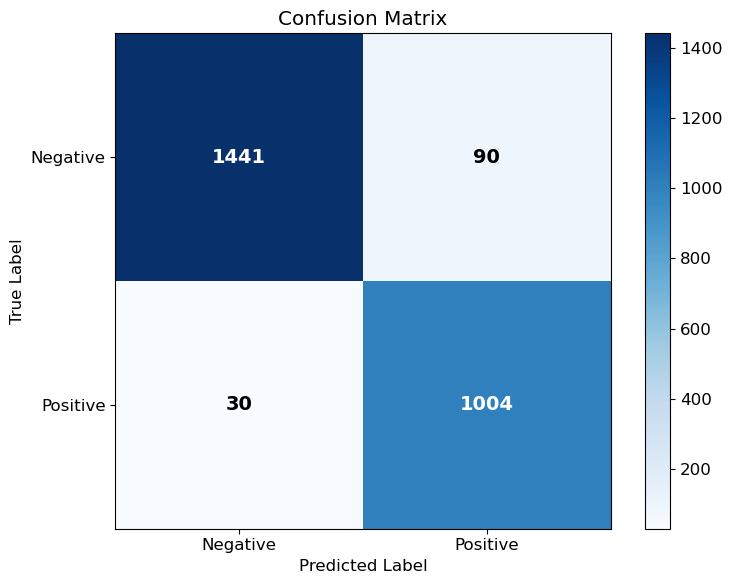

✓ Model evaluation complete!


In [115]:
# Evaluate on validation set
print("=" * 60)
print("DETAILED VALIDATION EVALUATION")
print("=" * 60)

# Get predictions
y_val_pred_proba = model.predict(X_val, verbose=0)
y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(f"                Predicted")
print(f"              Negative  Positive")
print(f"Actual Negative   {tn:4d}      {fp:4d}")
print(f"        Positive   {fn:4d}      {tp:4d}")
print()

# Classification Report
# zero_division=0: Suppress warnings when a class has no predicted samples (can happen in early epochs)
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Negative', 'Positive'], zero_division=0))
print()

# Additional Metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
# zero_division=0: Suppress warnings when a class has no predicted samples
f1 = f1_score(y_val, y_val_pred, zero_division=0)
roc_auc = roc_auc_score(y_val, y_val_pred_proba)

print("Detailed Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print()

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Negative', 'Positive'],
       yticklabels=['Negative', 'Positive'],
       title='Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Model evaluation complete!")
